In [1]:
import arviz as az
import jax.numpy as jnp
import numpyro
import matplotlib.pylab as plt
import numpyro.distributions as dist
from jax import random
import numpy.random as rand

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80

In [2]:
# cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Peak_sigmoid/cdf_files/CBC_z_0_4.cdf"
# cdf_file_bigger_prior_delta = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Peak_sigmoid/cdf_files/CBCO3_larger_prior_on_delta_mu.cdf"
# "./RUNS/CBC_O3_Peak.cdf"
cdf_file = "../data/RUNS/peak_run_no_delta_middle_z_until_0dot08.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))
samps_big = samps
# data_big = az.from_netcdf(cdf_file_bigger_prior_delta)
# samps_big = data.posterior.stack(draws=("chain", "draw"))

In [3]:
def sigmoid(low, delta, width, middle, zs):
    return delta / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

zs = np.linspace(0,2,500)

In [4]:
new_priors = {
    "logR20":dist.Uniform(-2,1),
    "alpha_ref":dist.Normal(-2,3),
    "mu_m1":dist.Uniform(15,60), # 20, 50
    "mMin":dist.Uniform(5,15),
    "bq":dist.Normal(0,3),
    "alpha_z":dist.Normal(0,4),
    "beta_z":dist.Uniform(0,10),
    "zp": dist.Uniform(0,4),
    "fpeak": dist.Uniform(-6,0),
    "log_high_f_peak": dist.Uniform(-6,0),
    "width_f_peak": dist.Uniform(-1,1),
    "middle_z_f_peak": dist.Uniform(0,0.8), # was 0 4
    "high_mu": dist.Uniform(15, 60), # delta was normal mean 0 std 10
    "width_mu": dist.Uniform(-1,1),
    "middle_z_mu": dist.Uniform(0,0.8),
    "sig_m1": dist.Uniform(1.5,15),
    "high_sig": dist.Uniform(1.5,15),
    "width_sig": dist.Uniform(-1,1),
    "middle_z_sig": dist.Uniform(0,0.8),
}

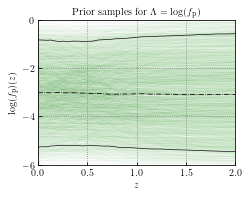

In [5]:
cm = 1/2.54
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_log_f_peak = rand.uniform(-6,0, samps.log_f_peak.size)
prior_high_f_peak = rand.uniform(-6,0, samps.log_f_peak.size)
prior_width_f_peak = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_f_peak = rand.uniform(0, 0.8, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(prior_log_f_peak[i],
                               prior_high_f_peak[i],
                               10.**prior_width_f_peak[i],
                               prior_middle_f_peak[i],
                               zs,
                              )
    ax1.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-6, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
only_prior_fp_median = median_fp
only_prior_fp_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_fp_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior samples for $\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Prior_trace_f_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

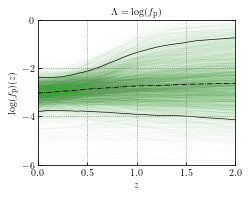

In [7]:
cm = 1/2.54
fig1, ax1 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax1.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    ax1.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-6, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Trace_f_peak_peak_z_0_to_2.pdf", dpi=400, bbox_inches='tight')
plt.show()

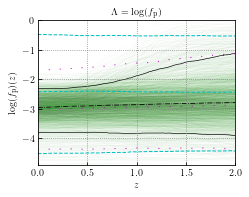

In [19]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-6, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_fp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_fp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_fp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_fp_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_fp_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_fp_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r"$\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Trace_f_peak_peak_with_prior_and_prior_plus_posterior.pdf", dpi=400, bbox_inches='tight')
plt.show()

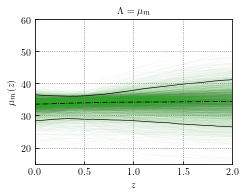

In [9]:
cm = 1/2.54
fig2, ax2 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax2.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
for i in range(samps.mu_m1.size):
    mu_r = sigmoid_no_delta(samps.mu_m1.values[i],
                               samps.high_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               zs,
                              )
    ax2.plot(zs, mu_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(15, 60)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax2.plot(zs, median_mu, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Trace_mu_peak_z_0_to_2.pdf", dpi=400, bbox_inches='tight')
plt.show()

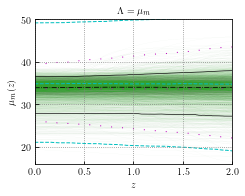

In [20]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
for i in range(samps.mu_m1.size):
    mu_r = sigmoid(samps.mu_m1.values[i],
                               samps.delta_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               zs,
                              )
    plt.plot(zs, mu_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(16, 50)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_mu, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_mu_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_mu_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Trace_mu_peak_prior_and_prior_plus_posterior.pdf", dpi=400, bbox_inches='tight')
plt.show()

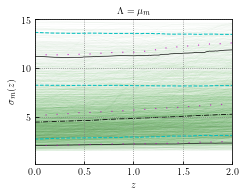

In [21]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
for i in range(samps.mu_m1.size):
    sig_r = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    plt.plot(zs, sig_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r

median_sig = np.median(sig_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(0.2, 15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_sig, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_sigma_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_sigma_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_sigma_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_sigma_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Trace_sigma_peak_prior_and_prior_plus_posterior.pdf", dpi=400, bbox_inches='tight')
plt.show()

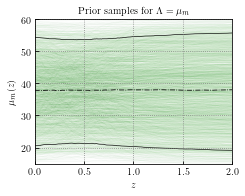

In [6]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_mu = rand.uniform(15, 60, samps.log_f_peak.size)
prior_high_mu = rand.uniform(15, 60, samps.log_f_peak.size)
prior_width_mu = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_mu = rand.uniform(0, 0.8, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(prior_mu[i],
                               prior_high_mu[i],
                               10.**prior_width_mu[i],
                               prior_middle_mu[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(15, 60)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
only_prior_mu_median = median_fp
only_prior_mu_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_mu_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior samples for $\Lambda = \mu_m$", fontsize = 10)
plt.savefig("Prior_trace_mu.pdf", dpi=400, bbox_inches='tight')
plt.show()

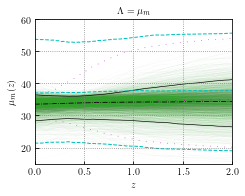

In [15]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps_big.mu_m1.size)), len(zs)))
mu_matrix_post = np.zeros((len(range(samps_big.mu_m1.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps_big.high_mu.values))
for i in range(samps_big.mu_m1.size):
    prior_high_mu = rand.uniform(15, 60)
    prior_width_mu = rand.uniform(-1,1)
    prior_middle_mu = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_no_delta(samps_big.mu_m1.values[i],
                               samps_big.high_mu.values[i],
                               10.**samps_big.log_width_mu.values[i],
                               samps_big.middle_z_mu.values[i],
                               0,
                              )
    value_at_z_0 = samps_big.mu_m1.values[i] + (
        (samps_big.high_mu.values[i] - samps_big.mu_m1.values[i])/(1 + np.exp(samps_big.middle_z_mu.values[i]/samps_big.width_mu.values[i]))
    )
    intermediate_step_prior = np.exp(prior_middle_mu/(10**(prior_width_mu)))
    low_z_value_mu = (prior_high_mu - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_mu
    
    # value_at_z_0 = samps_big.mu_m1.values[i] + (samps_big.delta_mu.values[i])/(1 + np.exp(samps_big.middle_z_mu.values[i]/samps_big.width_mu.values[i]))
    # low_z_value_mu = posterior_value_z_0 - ( prior_delta_mu ) / ( 1 + jnp.exp( prior_middle_mu / 10**prior_width_mu ) )

    mu_r = sigmoid_no_delta(low_z_value_mu,
                               prior_high_mu,
                               10.**prior_width_mu,
                               prior_middle_mu,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r
    
    mu_r_post = sigmoid_no_delta(samps_big.mu_m1.values[i],
                               samps_big.high_mu.values[i],
                               10.**samps_big.log_width_mu.values[i],
                               samps_big.middle_z_mu.values[i],
                               zs,
                              )
    plt.plot(zs, mu_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix_post[i, :] = mu_r_post

median_mu = np.median(mu_matrix, axis = 0)
median_mu_post = np.median(mu_matrix_post, axis = 0)
plt.xlim(0,2)
plt.ylim(15, 60)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_mu_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(mu_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(mu_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, median_mu, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,10)))
plt.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,10)))
plt.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,10)))
plt.plot(zs, only_prior_mu_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_z_0.pdf", dpi=400, bbox_inches='tight')
plt.show()

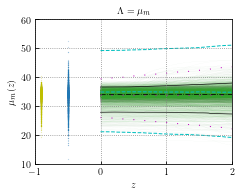

In [23]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps_big.mu_m1.size)), len(zs)))
value_at_0_matrix_only_post = np.zeros(len(samps_big.delta_mu.values))
for i in range(samps_big.mu_m1.size):
    mu_r = sigmoid(samps_big.mu_m1.values[i],
                               samps_big.delta_mu.values[i],
                               10.**samps_big.log_width_mu.values[i],
                               samps_big.middle_z_mu.values[i],
                               zs,
                              )
    value_at_z_0 = samps_big.mu_m1.values[i] + (samps_big.delta_mu.values[i])/(1 + np.exp(samps_big.middle_z_mu.values[i]/samps_big.width_mu.values[i]))
    value_at_0_matrix_only_post[i] = value_at_z_0
    plt.plot(zs, mu_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
plt.xlim(-1,2)
plt.ylim(10, 60)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_mu, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_mu_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_mu_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_mu_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_mu_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \mu_{m}$", fontsize = 10)
plt.savefig("Trace_mu_peak_prior_and_prior_plus_posterior_big_prior_delta_mu.pdf", dpi=400, bbox_inches='tight')
plt.show()

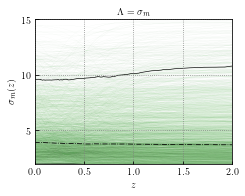

In [5]:
cm = 1/2.54
fig3, ax3 = plt.subplots(figsize=(9*cm, 6.75*cm))
ax3.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
for i in range(samps.sig_m1.size):
    sig_r = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    ax3.plot(zs, sig_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r

median_sig = np.median(sig_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(2.01,15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax3.plot(zs, median_sig, "-.", c="k", zorder = 1, lw = 0.8)
ax3.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax3.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.title(r'$\Lambda = \sigma_{m}$', fontsize = 10)
plt.savefig("Trace_sigma_peak_z_0_to_2.pdf", dpi=400, bbox_inches='tight')
plt.show()

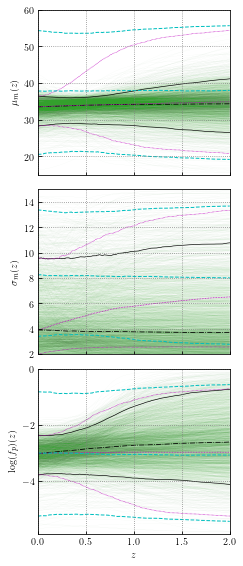

In [11]:
cm = 1/2.54
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9*cm, 3*6.75*cm))
cm = 1/2.54

ax1.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps_big.mu_m1.size)), len(zs)))
mu_matrix_post = np.zeros((len(range(samps_big.mu_m1.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps_big.high_mu.values))
for i in range(samps_big.mu_m1.size):
    prior_high_mu = rand.uniform(15, 60)
    prior_width_mu = rand.uniform(-1,1)
    prior_middle_mu = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_no_delta(samps_big.mu_m1.values[i],
                               samps_big.high_mu.values[i],
                               10.**samps_big.log_width_mu.values[i],
                               samps_big.middle_z_mu.values[i],
                               0,
                              )
    value_at_z_0 = samps_big.mu_m1.values[i] + (
        (samps_big.high_mu.values[i] - samps_big.mu_m1.values[i])/(1 + np.exp(samps_big.middle_z_mu.values[i]/samps_big.width_mu.values[i]))
    )
    intermediate_step_prior = np.exp(prior_middle_mu/(10**(prior_width_mu)))
    low_z_value_mu = (prior_high_mu - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_mu
    
    # value_at_z_0 = samps_big.mu_m1.values[i] + (samps_big.delta_mu.values[i])/(1 + np.exp(samps_big.middle_z_mu.values[i]/samps_big.width_mu.values[i]))
    # low_z_value_mu = posterior_value_z_0 - ( prior_delta_mu ) / ( 1 + jnp.exp( prior_middle_mu / 10**prior_width_mu ) )

    mu_r = sigmoid_no_delta(low_z_value_mu,
                               prior_high_mu,
                               10.**prior_width_mu,
                               prior_middle_mu,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r
    
    mu_r_post = sigmoid_no_delta(samps_big.mu_m1.values[i],
                               samps_big.high_mu.values[i],
                               10.**samps_big.log_width_mu.values[i],
                               samps_big.middle_z_mu.values[i],
                               zs,
                              )
    ax1.plot(zs, mu_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix_post[i, :] = mu_r_post

median_mu = np.median(mu_matrix, axis = 0)
median_mu_post = np.median(mu_matrix_post, axis = 0)
ax1.set_ylim(15, 60)
ax1.set_ylabel(r"$\mu_{m}(z)$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(zs, median_mu_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(zs,np.quantile(mu_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(zs,np.quantile(mu_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(zs, median_mu, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax1.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax1.plot(zs, only_prior_mu_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(zs, only_prior_mu_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(zs, only_prior_mu_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

ax2.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps_big.sig_m1.size)), len(zs)))
sig_matrix_post = np.zeros((len(range(samps_big.sig_m1.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps_big.sig_m1.values))
for i in range(samps_big.sig_m1.size):
    prior_sig = rand.uniform(1.5,15)
    prior_high_sig = rand.uniform(1.5,15)
    prior_width_sig = rand.uniform(-1,1)
    prior_middle_sig = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_no_delta(samps_big.sig_m1.values[i],
                               samps_big.high_sig.values[i],
                               10.**samps_big.log_width_sig.values[i],
                               samps_big.middle_z_sig.values[i],
                               0,
                              )


    value_at_z_0 = samps_big.sig_m1.values[i] + (
        (samps_big.high_sig.values[i] - samps_big.sig_m1.values[i])/(1 + np.exp(samps_big.middle_z_sig.values[i]/samps_big.width_sig.values[i]))
    )
    intermediate_step_prior = np.exp(prior_middle_sig/(10**(prior_width_sig)))
    low_z_value_sig = (prior_high_sig - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_sig
    sig_r = sigmoid_no_delta(low_z_value_sig,
                               prior_high_sig,
                               10.**prior_width_sig,
                               prior_middle_sig,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r
    
    sig_r_post = sigmoid_no_delta(samps_big.sig_m1.values[i],
                               samps_big.high_sig.values[i],
                               10.**samps_big.log_width_sig.values[i],
                               samps_big.middle_z_sig.values[i],
                               zs,
                              )
    ax2.plot(zs, sig_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix_post[i, :] = sig_r_post

median_sig = np.median(sig_matrix, axis = 0)
median_sig_post = np.median(sig_matrix_post, axis = 0)
ax2.set_ylim(2, 15)
ax2.set_ylabel(r"$\sigma_{m}(z)$", fontsize = 10)
ax2.tick_params(axis='y', labelsize=10)
ax2.plot(zs, median_sig_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(zs,np.quantile(sig_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(zs,np.quantile(sig_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(zs, median_sig, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax2.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax2.plot(zs, only_prior_sigma_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(zs, only_prior_sigma_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(zs, only_prior_sigma_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

ax3.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))
fp_matrix_post = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps_big.log_f_peak.values))
for i in range(samps_big.log_f_peak.size):
    prior_fpeak = rand.uniform(-6, 0)
    prior_high_fpeak = rand.uniform(-6, 0)
    prior_width_fpeak = rand.uniform(-1,1)
    prior_middle_fpeak = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_no_delta(samps_big.log_f_peak.values[i],
                               samps_big.log_high_f_peak.values[i],
                               10.**samps_big.log_width_f_peak.values[i],
                               samps_big.middle_z_f_peak.values[i],
                               0,
                              )

    intermediate_step = 1 + np.exp(samps_big.middle_z_f_peak.values[i]/samps_big.width_f_peak.values[i])
    value_at_z_0 = samps_big.log_f_peak.values[i] + (
        (samps_big.log_high_f_peak.values[i] - samps_big.log_f_peak.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_fpeak/(10**(prior_width_fpeak)))
    low_z_value_fp = (prior_high_fpeak - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
    # posterior_value_z_0 - ( prior_high_fpeak - prior_fpeak ) / ( 1 + jnp.exp( prior_middle_fpeak / 10**prior_width_fpeak ) )

    low_value_z_matrix[i] = low_z_value_fp
    fp_r = sigmoid_no_delta(low_z_value_fp,
                               prior_high_fpeak,
                               10.**prior_width_fpeak,
                               prior_middle_fpeak,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = fp_r
    
    fp_r_post = sigmoid_no_delta(samps_big.log_f_peak.values[i],
                               samps_big.log_high_f_peak.values[i],
                               10.**samps_big.log_width_f_peak.values[i],
                               samps_big.middle_z_f_peak.values[i],
                               zs,
                              )
    ax3.plot(zs, fp_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix_post[i, :] = fp_r_post

median_fp = np.median(fp_matrix, axis = 0)
median_fp_post = np.median(fp_matrix_post, axis = 0)
ax3.set_xlim(0,2)
ax3.set_ylim(-5.9, 0)
ax3.set_xlabel(r"$z$", fontsize = 10)
ax3.set_ylabel(r"$\log(f_p)(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax3.plot(zs, median_fp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax3.plot(zs,np.quantile(fp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax3.plot(zs,np.quantile(fp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax3.plot(zs, median_fp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax3.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax3.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,1)))
ax3.plot(zs, only_prior_fp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax3.plot(zs, only_prior_fp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax3.plot(zs, only_prior_fp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("One_plot_conditional_prior.pdf", dpi=500, bbox_inches="tight")
plt.show()

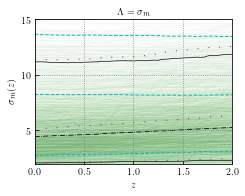

In [24]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
for i in range(samps.sig_m1.size):
    sig_r = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    plt.plot(zs, sig_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r

median_sig = np.median(sig_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(2.01,15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_sig, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, only_prior_sigma_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, prior_posterior_sigma_median, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_sigma_quantile_5, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.plot(zs, prior_posterior_sigma_quantile_95, zorder = 1, color='m', lw=1, linestyle=(0,(1,10)))
plt.title(r'$\Lambda = \sigma_{m}$', fontsize = 10)
plt.savefig("Trace_sigma_peak_prior_and_prior_plus_posterior.pdf", dpi=400, bbox_inches='tight')
plt.show()

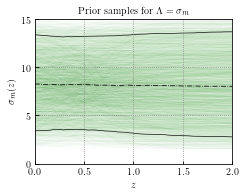

In [7]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_sigma = rand.uniform(1.5,15, samps.log_f_peak.size)
prior_high_sigma = rand.uniform(1.5,15, samps.log_f_peak.size)
prior_width_sigma = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_sigma = rand.uniform(0, 0.8, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(prior_sigma[i],
                               prior_high_sigma[i],
                               10.**prior_width_sigma[i],
                               prior_middle_sigma[i],
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(0, 15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
only_prior_sigma_median = median_fp
only_prior_sigma_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_sigma_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior samples for $\Lambda = \sigma_m$", fontsize = 10)
plt.savefig("Prior_trace_sigma.pdf", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
cm = 1/2.54
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9*cm, 3*6.75*cm))

ax1.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    ax1.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
ax1.set_ylim(-4.9, 0)
ax1.set_ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
ax1.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)

ax2.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
for i in range(samps.mu_m1.size):
    mu_r = sigmoid(samps.mu_m1.values[i],
                               samps.delta_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               zs,
                              )
    ax2.plot(zs, mu_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix[i, :] = mu_r

median_mu = np.median(mu_matrix, axis = 0)
ax2.set_ylim(16, 50)
ax2.set_ylabel(r"$\mu_{m}(z) [M_\odot]$", fontsize = 10)
ax2.tick_params(axis='y', labelsize=10)
ax2.plot(zs, median_mu, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)



ax3.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
for i in range(samps.sig_m1.size):
    sig_r = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    ax3.plot(zs, sig_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r

median_sig = np.median(sig_matrix, axis = 0)
ax3.set_xlim(0,2)
ax3.set_ylim(2.01,15)
ax3.set_xlabel(r"$z$", fontsize = 10)
ax3.set_ylabel(r"$\sigma_{m}(z) [M_\odot]$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax3.plot(zs, median_sig, "-.", c="k", zorder = 1, lw = 0.8)
ax3.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax3.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("test_one_plot.pdf", dpi=500, bbox_inches="tight")
plt.show()

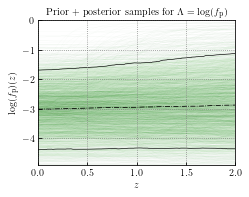

In [16]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

posterior_low_f_peak = samps.log_f_peak.values

for i in range(samps.log_f_peak.size):
    prior_sample_high_f_peak = rand.uniform(-5,0)
    prior_sample_width_f_peak = rand.uniform(-1,1)
    prior_sample_middle_f_peak = rand.uniform(0,4)
    f_peak_r = sigmoid_no_delta(posterior_low_f_peak[i],
                               prior_sample_high_f_peak,
                               10.**prior_sample_width_f_peak,
                               prior_sample_middle_f_peak,
                               zs,
                              )
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(-4.9, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_{\rm p})(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
prior_posterior_fp_median = median_fp
prior_posterior_fp_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
prior_posterior_fp_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior + posterior samples for $\Lambda = \log(f_{\rm p})$", fontsize = 10)
plt.savefig("Prior_and_posterior_trace_f_peak.pdf", dpi=400, bbox_inches='tight')
plt.show()

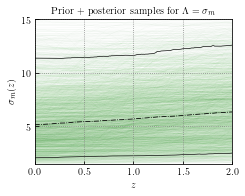

In [17]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))
value_at_0_matrix = np.zeros(samps.mu_m1.size)

posterior_low_sigma = samps_big.sig_m1.values

for i in range(samps_big.log_f_peak.size):
    prior_sample_high_sig = rand.uniform(1.5,15)
    prior_sample_width_sig = rand.uniform(-1,1)
    prior_sample_middle_sig = rand.uniform(0,4)
    f_peak_r = sigmoid_no_delta(posterior_low_sigma[i],
                               prior_sample_high_sig,
                               10.**prior_sample_width_sig,
                               prior_sample_middle_sig,
                               zs,
                              )
    value_at_z_0 = posterior_low_sigma[i] + (prior_sample_high_sig - posterior_low_sigma[i])/(1 + np.exp(prior_sample_middle_sig/10**prior_sample_width_sig))
    value_at_0_matrix[i] = value_at_z_0
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(0,2)
plt.ylim(1.5, 15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
prior_posterior_sigma_median = median_fp
prior_posterior_sigma_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
prior_posterior_sigma_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior + posterior samples for $\Lambda = \sigma_m$", fontsize = 10)
plt.savefig("Prior_and_posterior_trace_sigma.pdf", dpi=400, bbox_inches='tight')
plt.show()

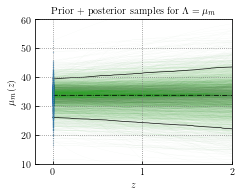

In [18]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))
value_at_0_matrix = np.zeros(samps.mu_m1.size)

posterior_low_mu = samps_big.mu_m1.values

for i in range(samps_big.log_f_peak.size):
    prior_sample_delta_mu = rand.normal(0,10)
    prior_sample_width_mu = rand.uniform(-1,1)
    prior_sample_middle_mu = rand.uniform(0,4)
    f_peak_r = sigmoid(posterior_low_mu[i],
                               prior_sample_delta_mu,
                               10.**prior_sample_width_mu,
                               prior_sample_middle_mu,
                               zs,
                              )
    value_at_z_0 = posterior_low_mu[i] + (prior_sample_delta_mu)/(1 + np.exp(prior_sample_middle_mu/10**prior_sample_width_mu))
    value_at_0_matrix[i] = value_at_z_0
    plt.plot(zs, f_peak_r, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = f_peak_r

median_fp = np.median(fp_matrix, axis = 0)
plt.xlim(-0.2,2)
plt.ylim(10, 60)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\mu_m(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.scatter(np.zeros(len(value_at_0_matrix)),value_at_0_matrix, s=0.01)
prior_posterior_mu_median = median_fp
prior_posterior_mu_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
prior_posterior_mu_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)
plt.title(r"Prior + posterior samples for $\Lambda = \mu_m$", fontsize = 10)
plt.savefig("Prior_and_posterior_trace_mu.pdf", dpi=400, bbox_inches='tight')
plt.show()

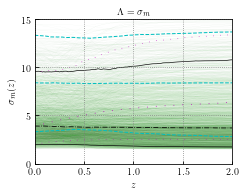

In [7]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps_big.sig_m1.size)), len(zs)))
sig_matrix_post = np.zeros((len(range(samps_big.sig_m1.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps_big.sig_m1.values))
for i in range(samps_big.sig_m1.size):
    prior_sig = rand.uniform(1.5,15)
    prior_high_sig = rand.uniform(1.5,15)
    prior_width_sig = rand.uniform(-1,1)
    prior_middle_sig = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_no_delta(samps_big.sig_m1.values[i],
                               samps_big.high_sig.values[i],
                               10.**samps_big.log_width_sig.values[i],
                               samps_big.middle_z_sig.values[i],
                               0,
                              )


    value_at_z_0 = samps_big.sig_m1.values[i] + (
        (samps_big.high_sig.values[i] - samps_big.sig_m1.values[i])/(1 + np.exp(samps_big.middle_z_sig.values[i]/samps_big.width_sig.values[i]))
    )
    intermediate_step_prior = np.exp(prior_middle_sig/(10**(prior_width_sig)))
    low_z_value_sig = (prior_high_sig - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)

    low_value_z_matrix[i] = low_z_value_sig
    sig_r = sigmoid_no_delta(low_z_value_sig,
                               prior_high_sig,
                               10.**prior_width_sig,
                               prior_middle_sig,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    sig_matrix[i, :] = sig_r
    
    sig_r_post = sigmoid_no_delta(samps_big.sig_m1.values[i],
                               samps_big.high_sig.values[i],
                               10.**samps_big.log_width_sig.values[i],
                               samps_big.middle_z_sig.values[i],
                               zs,
                              )
    plt.plot(zs, sig_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix_post[i, :] = sig_r_post

median_sig = np.median(sig_matrix, axis = 0)
median_sig_post = np.median(sig_matrix_post, axis = 0)
plt.xlim(0,2)
plt.ylim(0, 15)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\sigma_{m}(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_sig_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(sig_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(sig_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, median_sig, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,10)))
plt.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,10)))
plt.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,10)))
plt.plot(zs, only_prior_sigma_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_sigma_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \sigma_{m}$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_z_0_sigma.pdf", dpi=400, bbox_inches='tight')
plt.show()

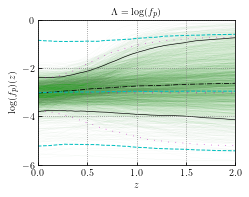

In [11]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(9*cm, 6.75*cm))
ax.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))
fp_matrix_post = np.zeros((len(range(samps_big.log_f_peak.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps_big.log_f_peak.values))
for i in range(samps_big.log_f_peak.size):
    prior_fpeak = rand.uniform(-6, 0)
    prior_high_fpeak = rand.uniform(-6, 0)
    prior_width_fpeak = rand.uniform(-1,1)
    prior_middle_fpeak = rand.uniform(0, 0.8)
    posterior_value_z_0 = sigmoid_no_delta(samps_big.log_f_peak.values[i],
                               samps_big.log_high_f_peak.values[i],
                               10.**samps_big.log_width_f_peak.values[i],
                               samps_big.middle_z_f_peak.values[i],
                               0,
                              )

    intermediate_step = 1 + np.exp(samps_big.middle_z_f_peak.values[i]/samps_big.width_f_peak.values[i])
    value_at_z_0 = samps_big.log_f_peak.values[i] + (
        (samps_big.log_high_f_peak.values[i] - samps_big.log_f_peak.values[i])/(intermediate_step)
    )
    intermediate_step_prior = np.exp(prior_middle_fpeak/(10**(prior_width_fpeak)))
    low_z_value_fp = (prior_high_fpeak - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
    # posterior_value_z_0 - ( prior_high_fpeak - prior_fpeak ) / ( 1 + jnp.exp( prior_middle_fpeak / 10**prior_width_fpeak ) )

    low_value_z_matrix[i] = low_z_value_fp
    fp_r = sigmoid_no_delta(low_z_value_fp,
                               prior_high_fpeak,
                               10.**prior_width_fpeak,
                               prior_middle_fpeak,
                               zs,
                              )
    # plt.plot(zs, mu_r, lw = 0.05, color='m', alpha = 0.2, zorder = 1)
    fp_matrix[i, :] = fp_r
    
    fp_r_post = sigmoid_no_delta(samps_big.log_f_peak.values[i],
                               samps_big.log_high_f_peak.values[i],
                               10.**samps_big.log_width_f_peak.values[i],
                               samps_big.middle_z_f_peak.values[i],
                               zs,
                              )
    plt.plot(zs, fp_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix_post[i, :] = fp_r_post

median_fp = np.median(fp_matrix, axis = 0)
median_fp_post = np.median(fp_matrix_post, axis = 0)
plt.xlim(0,2)
plt.ylim(-6, 0)
plt.xlabel(r"$z$", fontsize = 10)
plt.ylabel(r"$\log(f_p)(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(zs, median_fp_post, "-.", c="k", zorder = 1, lw = 0.8)
plt.plot(zs,np.quantile(fp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs,np.quantile(fp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
plt.plot(zs, median_fp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,10)))
plt.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,10)))
plt.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='m', lw=0.65, alpha=1, linestyle=(0,(1,10)))
plt.plot(zs, only_prior_fp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_fp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
plt.plot(zs, only_prior_fp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")
# plt.scatter(np.zeros(len(value_at_0_matrix))-0.5, value_at_0_matrix, s=0.01)
# plt.scatter(np.ones(len(value_at_0_matrix_only_post))-1.9, value_at_0_matrix_only_post, s=0.01, c="y")
plt.title(r"$\Lambda = \log(f_p)$", fontsize = 10)
plt.savefig("Prior_random_tuning_to_posterior_at_z_0_fp.pdf", dpi=400, bbox_inches='tight')
plt.show()